# Finding Frequent Itemsets (Apriori)

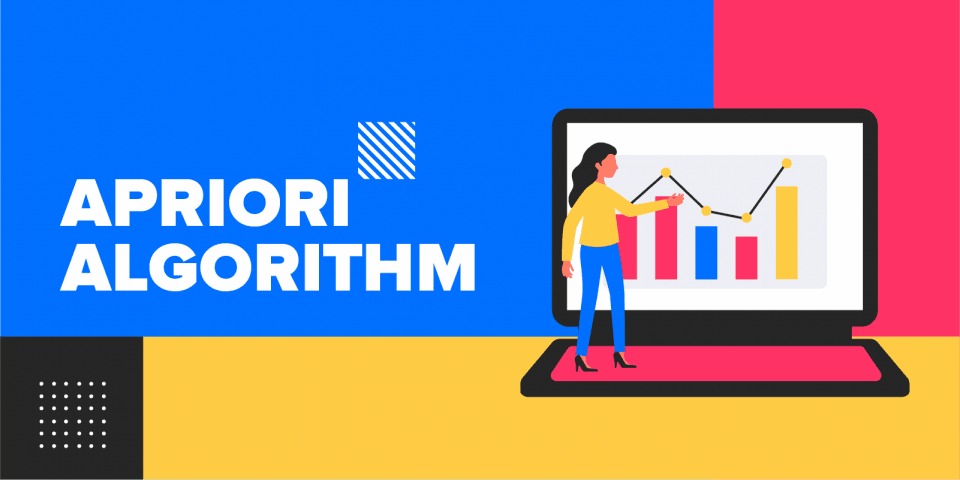

In this notebook, I will demonstrate the pipeline of turning "purchase history" into an information that can be utilized.



In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext, SparkConf

In [3]:
import sys
import time
from itertools import combinations
import pandas as pd

In [4]:
support = 4

In [5]:
def case_reader(case,bucket):
    if int(case) == 1:
        return (bucket[0], bucket[1])
    elif int(case) == 2:
        return (bucket[1], bucket[0])

In [6]:
conf = SparkConf().setAppName("task1").setMaster("local[*]")
sc = SparkContext(conf=conf)

### Main Idea <br>

Looking at the purchase history, we will analyze whether there are particular patterns. <br>
To do so, there are several steps:

1. Turn data into "baskets"
2. Decide on a threshold (a value, if exceeded, that determines whether an item is frequent or not)
- For this case, our threshold will be FOUR.
3. Using the threshold, determine whether each item is frequent.
4. Using this prior knowledge of frequent single items, we will expand further to pairs, triplets, and more to find all frequent itemsets.

### Initial Data 

Our data is rows with two columns: user id and business id. <br>
We will first transform and aggregate these rows into "baskets."

In [7]:
df = pd.read_csv('small1.csv')

In [8]:
df.head(10)

,user_id,business_id
0,1,100
1,1,98
2,1,101
3,1,102
4,2,101
5,2,99
6,2,97
7,2,100
8,3,98
9,3,103


Here, while we don't know the user ids, we know the "basket" or what they have purchased together. <br>
By analyzing this data, we will determine what combinations of items occur frequently enough.

In [9]:
rdd = sc.textFile('small1.csv').filter(lambda x: x != "user_id,business_id").map(lambda x: x.split(",")).map(lambda x: case_reader(1,x)).groupByKey().mapValues(set).map(lambda x: x[1])
#rdd = sc.textFile('small1.csv').filter(lambda x: x != "user_id,business_id").map(lambda x: x.split(",")).map(lambda x: case_reader(2,x)).groupByKey().mapValues(set).map(lambda x: x[1])
#rdd = sc.textFile('small2.csv').filter(lambda x: x != "user_id,business_id").map(lambda x: x.split(",")).map(lambda x: case_reader(1,x)).groupByKey().mapValues(set).map(lambda x: x[1])
#rdd = sc.textFile('small2.csv').filter(lambda x: x != "user_id,business_id").map(lambda x: x.split(",")).map(lambda x: case_reader(2,x)).groupByKey().mapValues(set).map(lambda x: x[1])

In [10]:
rdd.collect()

[{'102', '103', '105', '97', '98', '99'},
 {'101', '102', '103', '97', '99'},
 {'97', '98'},
 {'101', '102'},
 {'101', '97', '99'},
 {'97', '98'},
 {'100', '101', '102', '103', '105', '106', '107', '108', '98', '99'},
 {'97'},
 {'101', '97', '99'},
 {'100', '101', '98', '99'},
 {'97', '99'},
 {'97', '98', '99'},
 {'100', '101', '102', '98'},
 {'100', '101', '97', '99'},
 {'102', '103', '104', '97', '98', '99'},
 {'97', '98', '99'},
 {'97', '98', '99'},
 {'100', '101', '102', '105', '106', '107', '108', '98'},
 {'102', '97', '98'}]

In [11]:
# importatnt to count after we remove duplicates by using sets

total_count = rdd.flatMap(lambda x: x).count()
total_count

74

#### def max_count_item_count(baskets):

This function returns the total number of items, as well as the biggest size basket. <br>
- Total Number of Items: will be used when applying SON algorithm (because SON algorithm intakes subsets of data at a time, we need to know the total number of items to proportionally reduce the threshold.
- Biggest Size Basket: will be used as a guide in terms of knowing how big of a combinations we must check for Apriori.

In [12]:
def max_count_item_count(baskets):
    max_count = 0
    temp_count = 0
    item_count = 0
    for basket in baskets:
        for item in basket:
            temp_count+=1
            item_count+=1 
        if temp_count > max_count:
            max_count = temp_count
        
        temp_count = 0
        
    return max_count, item_count

#### def single(baskets,item_count,sup,total):
This function counts the frequency of each unique items to determine whether they have surpassed the threshold.

* Because we are using SON algorithm, meaning we will handle subset of the data at a time, we need to recaliberate threshold value using # of items in the chunk, total colunt, and initial threshold value.

- The function utilizes hashing/dictionary to count the frequency of each item. And, if the frequency exceeds our threshold, we will add it to our set named result, which will be returned at the end.

In [13]:
def single(baskets,item_count,sup,total):
    
    result = set()
    temp_set = set()
    temp_dict = {}
    p = item_count / total * sup
    for basket in baskets:
        temp_set.update(basket)
        
    temp_set = {frozenset([item]) for item in temp_set}
    
    for item in temp_set:
        temp_dict[item] = 0
    
    for basket in baskets:
        for item in temp_dict:
            if item.issubset(basket):
                temp_dict[item] += 1
        
    for item in temp_dict:
        if temp_dict[item] >= p:
            result.add(item)
            
    return sorted(result)

#### def multiple(baskets,single_frequent,max_count,item_count,sup,total):
This function serves similarly to the function "single" but does it for pairs, triplets, and more. <br>

- This function utilizes the result from "single" function. It uses the frequent singletons to build its pairs and so on. 
- Iteratively, it will build frequent set from size of 2 to biggest existing basket size.

In [14]:
def multiple(baskets,single_frequent,max_count,item_count,sup,total):
    
    final_result = set()
    previous_frequent = single_frequent
    p = item_count / total * sup
    for size in range(2,max_count+1,1):
        temp_set = set()
        temp_dict = {}
        temp_result = set()
        for i in previous_frequent:
            for j in previous_frequent:
                if len(i.union(j)) == size:
                    temp_set.update({i.union(j)})
        
        for item in temp_set:
            temp_dict[item] = 0
            
        for basket in baskets:
            for item in temp_dict:
                if item.issubset(basket):
                    temp_dict[item] += 1
                
        for item in temp_dict:
            if temp_dict[item] >= p:
                temp_result.add(item)

        temp_result = sorted(temp_result)
        previous_frequent = temp_result
        final_result.update(temp_result)
                
    return final_result

#### def apriori(iterator,sup,total):

This function initiates the "single" and "multiple" function and aggregates the result into final candidates.

In [15]:
def apriori(iterator,sup,total):
    baskets = []
    for basket in iterator:
        baskets.append(basket)
        
    max_count, item_count = max_count_item_count(baskets)
    
    singleton = single(baskets,item_count,sup,total)
    multiplet = multiple(baskets,singleton,max_count,item_count,sup,total)
    
    final_candidate = set()
    final_candidate.update(singleton)
    final_candidate.update(multiplet)
    
    yield final_candidate

#### def frequent(iterator,candidate_list):
This function uses prior knowledge to determine truly frequent itemsets. 
- The function utilizes the result from function "apriori".

In [16]:
def frequent(iterator,candidate_list):
    
    final_candidate = []
    temp_dict = {}
    baskets = []
    item_count = max_count_item_count(baskets)[1]
    for basket in iterator:
        baskets.append(basket)
    
    for item in candidate_list:
        temp_dict[item[0]] = 0
        
    for basket in baskets:
        for item in temp_dict:
            if item.issubset(basket):
                temp_dict[item] += 1
                            
    for i in temp_dict:
        final_candidate.append((i,temp_dict[i]))

    return final_candidate

#### Utility Functions

These functions below assist in displaying the result in orderly way.

- def length_sort(x):
- def custom_sort(a_list):
- def custom_print(candidate,frequent,output_file):

In [17]:
def length_sort(x):
    if type(x) == int:
        return 1
    else:
        return len(x)

In [18]:
def custom_sort(a_list):
    dict_for_each = {}
    begin = "("
    end = ")"
    
    for frequent in a_list:
        temp_text = ""
        if frequent[-1] not in list(dict_for_each.keys()):
            dict_for_each[frequent[-1]] = []
        
        if frequent[-1] == 1:
            for i in frequent[0]:
                temp_text = temp_text + "('"+i+"')"
        
        else:
            count = frequent[-1]
            temp = 0
            for i in sorted(list(frequent[0])):
                temp+=1
                if temp != count:
                    temp_text = temp_text+"'"+str(i)+"'"+", "
                else:
                    temp_text = temp_text+"'"+str(i)+"'"
            
            temp_text = begin+temp_text+end
        
        dict_for_each[frequent[-1]].append(temp_text)
        
    total_list = []
    for i in sorted(dict_for_each):
        total_list.append(sorted(dict_for_each[i]))
    
    return total_list         

In [19]:
def custom_print(candidate,frequent,output_file):
    candidate_header = "Candidates:"
    frequent_header = "Frequent Itemsets:"
    
    with open(output_file,"w") as outfile:
        outfile.write(candidate_header)
        outfile.write("\n")
        for i in range(0,len(candidate),1):
            for j in range(0,len(candidate[i]),1):
                if j != len(candidate[i]) - 1:
                    outfile.write(candidate[i][j]+",")
                else:
                    outfile.write(candidate[i][j])       
            outfile.write("\n")
            outfile.write("\n")
        
        outfile.write(frequent_header)
        outfile.write("\n")
        for i in range(0,len(frequent),1):
            counter = 0
            for j in range(0,len(frequent[i]),1):
                counter = j
                if j != len(frequent[i]) - 1:
                    outfile.write(frequent[i][j]+",")
                else:
                    outfile.write(frequent[i][j])
            if i != len(frequent)-1 and counter != len(frequent[i][j])-1:
                outfile.write("\n")
                outfile.write("\n")
            
    outfile.close()

In [23]:
candidate = rdd.mapPartitions(lambda x: apriori(x, support,total_count)).flatMap(lambda x:x).distinct().map(lambda x: (x,length_sort(x))).collect()

In [24]:
sorted_candidate = custom_sort(candidate)

In [25]:
for i in sorted_candidate:
    for j in i:
        print(j)
    print()

('100')
('101')
('102')
('103')
('97')
('98')
('99')

('100', '101')
('100', '102')
('100', '98')
('101', '102')
('101', '97')
('101', '98')
('101', '99')
('102', '103')
('102', '97')
('102', '98')
('102', '99')
('103', '99')
('97', '98')
('97', '99')
('98', '99')

('100', '101', '102')
('100', '101', '98')
('100', '102', '98')
('101', '102', '98')
('101', '97', '99')
('102', '103', '99')
('102', '97', '98')
('97', '98', '99')

('100', '101', '102', '98')



In [26]:
frequent_item = rdd.mapPartitions(lambda x: frequent(x,candidate)).reduceByKey(lambda a,b:a+b).filter(lambda x: x[1] >= support).map(lambda x: (x[0],length_sort(x[0]))).collect()

In [27]:
sorted_frequent_item = custom_sort(frequent_item)

In [29]:
for i in sorted_frequent_item:
    for j in i:
        print(j)
    print()

('100')
('101')
('102')
('103')
('97')
('98')
('99')

('100', '101')
('100', '98')
('101', '102')
('101', '97')
('101', '98')
('101', '99')
('102', '103')
('102', '97')
('102', '98')
('102', '99')
('103', '99')
('97', '98')
('97', '99')
('98', '99')

('100', '101', '98')
('101', '97', '99')
('102', '103', '99')
('97', '98', '99')



## Conclusion

We can see that the number of frequent item is less than that of candidate's. <br>
Meaning, while some item sets seemed frequent in chunks or subset, when confirmed upon the full dataset, it turned out to be not frequent. <br><br>
As our result, we have 25 frequent itemsets that we can utilize. By strategically positioning these items near each other or by increasing their visibility, stores may attempt to increase their sales. <br><br>
It is quite an insight given that we merely had rows and rows of data that don't mean much on itself.